In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from os.path import join
import matplotlib.pyplot as plt
import datetime as dt
import re
# path = join(os.getcwd(), "data")
offline_raw = pd.read_excel("./9._offline_total_7.xlsx")

In [18]:
import warnings

warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [19]:
def convert_to_nan(data):
    
    df = data.copy()
    
    columns = df.columns.to_list()
    for col in columns:
        df[col] = df[col].apply(lambda x: np.nan if x == "-" else x)
    
    return df


def drop_columns(data):
    
    df = data.copy()
    
    rm_columns = ["온라인 스토어", "사용 포인트", "적립 포인트", "사용 선불권", "배달팁(매출 포함x)", "결제메모", "주문 채널"]
    df = df.drop(rm_columns, axis = 1)
    
    return df


def date_conversion(data):
    
    df = data.copy()
    
    df["결제일시"] = df.loc[:, "결제일"] + " " + df.loc[:, "결제시간"]
    df["결제일시"] = pd.to_datetime(df["결제일시"])
    df["year"] = df["결제일시"].apply(lambda x: x.year)
    df["month"] = df["결제일시"].apply(lambda x: x.month)
    df["day"] = df["결제일시"].apply(lambda x: x.day)
    df["hour"] = df["결제일시"].apply(lambda x: x.hour)
    df["day_name"] = df["결제일시"].apply(lambda x: x.day_name())
    df["year_month"] = pd.to_datetime(df["결제일"]).dt.strftime("%Y-%m")
    
    return df


def add_weekend(data):
    
    df = data.copy()
    
    # 평일, 주말 구분
    # 0 = 평일, 1 = 주말
    df["is_weekend"] = df["day_name"].apply(lambda x: 1 if (x == "Sunday") | (x == "Saturday") else 0)
    
    return df


def add_season(data):
    
    df = data.copy()
    
    # 계절 추가하기
    # 봄(3~5월) = 1, 여름(6~8월) = 2, 가을(9~11월0) = 3, 겨울(12~2월) = 4
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    season_dict = dict(zip(range(1,13), seasons))
    df["season"] = df["month"].map(season_dict)

    return df


def add_holiday(data):
    
    df = data.copy()
    
    conditionlist = [
        (df['결제일'] == '2022-03-01') | (df['결제일'] == '2022-05-05') | (df['결제일'] == '2022-05-08') |
        (df['결제일'] == '2022-06-06') | (df['결제일'] == '2022-08-15') | (df['결제일'] == '2022-09-09') |
        (df['결제일'] == '2022-09-10') | (df['결제일'] == '2022-09-11') | (df['결제일'] == '2022-10-09') |
        (df['결제일'] == '2022-10-03') | (df['결제일'] == '2022-12-25') | 
        (df['결제일'] == '2023-01-01') | (df['결제일'] == '2023-01-21') | (df['결제일'] == '2023-01-22') |
        (df['결제일'] == '2023-01-23') | (df['결제일'] == '2023-03-01') | (df['결제일'] == '2023-05-05') |
        (df['결제일'] == '2023-05-26') | (df['결제일'] == '2023-06-06')]

    choicelist = [1]
    df['is_holiday'] = np.select(conditionlist, choicelist, default= 0)
    df["weekend_n_holiday"] = df["is_weekend"] + df["is_holiday"]
    
    return df

def drop_row(data):
    
    df = data.copy()
    df["상품명"] = df["상품명"].apply(lambda x: re.sub(r"\s", "", x))
    
    drop_lst = ['야외',
                '포장',
                '무료시음권', 
                '캐리어',
                '종이백',
                '포크',
                '⚪️',
                '⚪', # 위 emoji 와 별개
                '일회용컵',
               ]

    custom_lst = ['덜달게',
                  '1샷추가', 
                  '오틀리', 
                  '연하게', 
                  '시럽', 
                  '얼음적게',
                  '오트사이드', 
                  '물적게', 
                  '바닐라시럽', 
                  '2샷추가',
                  '얼음X',
                  '샷추가',
                 ]

    idx = df.loc[df["상품명"].str.contains("|".join(drop_lst)),"상품명"].index
    df = df.drop(idx, axis = 0).reset_index(drop = True)
    
    idx = df.loc[df["상품명"].str.contains("|".join(custom_lst)),"상품명"].index
    df.loc[idx, "카테고리"] = "커스텀"
    
    return df


In [20]:
def preprocess_productname(data):
    tmp = data.copy()
    tmp["카테고리"] = tmp["카테고리"].apply(lambda x: re.sub(r"\s", "", x))
    pattern = r'\s*_\s*'
    
    
    # 카테고리 - basic_ice
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(r"\s", "", x))
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(r"플랫_", "플랫화이트_", x))
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(r"템플", "I", x))

    beans_lst = ["클래식_", "쥬시_", "싱글_", "디카프_"]
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"][tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])
        
        
    # 카테고리 - basic
    tmp.loc[tmp["카테고리"] == "Basic", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "Basic", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic", "상품명"].apply(lambda x : re.sub(r"\s|\(H\)", "", x))
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "Basic", "상품명"][tmp.loc[tmp["카테고리"] == "Basic", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])
        
    idx = tmp.loc[tmp["카테고리"] == "Basic", "상품명"][tmp.loc[tmp["카테고리"] == "Basic", "상품명"].str.contains("아메리카노|카페라떼|플랫화이트|카푸치노|바닐라라떼")].index
    tmp.loc[idx, "상품명"] = tmp.loc[idx, "상품명"].apply(lambda x: "(H)"+x)
    
    
    # 카테고리 - 시그니처
    tmp.loc[tmp["카테고리"] == "시그니처", "상품명"] = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].apply(lambda x : re.sub(r"\s", "", x))
    tmp.loc[tmp["카테고리"] == "시그니처", "상품명"] = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].apply(lambda x : re.sub(r"아이스텐라", "아이스텐저린라떼", x))
    tmp.loc[tmp["카테고리"] == "시그니처", "상품명"] = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].apply(lambda x : re.sub(r"유자아메리카노|아이스유자아메리카노", "아이스유자아메리카노", x))
    
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"][tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])
        
    tmp.loc[tmp["상품명"] == "텐저린카푸치노", "상품명"] = "텐저린카푸치노_쥬시"
    tmp.loc[tmp["상품명"] == "아이스텐저린라떼", "상품명"] = "아이스텐저린라떼_쥬시"
    tmp.loc[tmp["상품명"] == "아이스유자아메리카노", "상품명"] = "아이스유자아메리카노_쥬시"
        
    # 카테고리 - beverage
    tmp.loc[tmp["카테고리"] == "비버리지", "상품명"] = tmp.loc[tmp["카테고리"] == "비버리지", "상품명"].apply(lambda x : re.sub(r"\s", "", x))
    
    rename_dict = {"차가운어린이우유": "(I)어린이우유",
                   "따뜻한어린이우유": "(H)어린이우유",
                   
                   "얼그레이밀크티": "(H)얼그레이밀크티",
                   
                   "제주유기농귤피주스" : "(I)제주유기농귤피주스",
                   "문경선암리사과주스" : "(I)문경선암리사과주스",
                   "제주유기농감귤주스" : "(I)제주유기농감귤주스",
                   "어린이감귤주스" : "(I)어린이감귤주스",
                   
                   "시나몬플럼" : "(H)시나몬플럼",
                   "트로피칼루이보스" : "(H)트로피칼루이보스",
                   "카모마일" : "(H)카모마일"
                  }
    
    tmp.loc[tmp["카테고리"] == "비버리지", "상품명"] = tmp.loc[tmp["카테고리"] == "비버리지", "상품명"].apply(lambda x: rename_dict[x] if x in rename_dict.keys() else x)
    tmp.loc[tmp["카테고리"] == "비버리지", "상품명"].value_counts()
    
    
    # 카테고리 - 디저트
    tmp.loc[tmp["카테고리"] == "디저트", "상품명"] = tmp.loc[tmp["카테고리"] == "디저트", "상품명"].apply(lambda x : re.sub(r"\s", r'_', x))
    
    
    # 카테고리 - 블랜딩원두
    tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"] = tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"] = tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"].apply(lambda x : re.sub(r"\s", r'_', x))
    
    
    # 카테고리 = 세트
    tmp.loc[tmp["카테고리"] == "세트", "상품명"] = tmp.loc[tmp["카테고리"] == "세트", "상품명"].apply(lambda x : re.sub(r"\s", '', x))
    tmp.loc[tmp["카테고리"] == "세트", "상품명"] = tmp.loc[tmp["카테고리"] == "세트", "상품명"].apply(lambda x : re.sub("Set.", "", x))
    
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "세트", "상품명"][tmp.loc[tmp["카테고리"] == "세트", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])
        
    tmp.loc[(tmp["카테고리"] == "세트") & (~tmp["상품명"].str.contains("(I)")), "상품명"] = tmp.loc[(tmp["카테고리"] == "세트") & (~tmp["상품명"].str.contains("(I)")), "상품명"].apply(lambda x : "(H)" + x)
    tmp.loc[tmp["카테고리"] == "세트", "상품명"] = tmp.loc[tmp["카테고리"] == "세트", "상품명"].apply(lambda x: "Set_" + x)
    
    
    # 카테고리 - 드립백/캡슐
    tmp.loc[tmp["카테고리"] == "드립백/캡슐", "상품명"] = tmp.loc[tmp["카테고리"] == "드립백/캡슐", "상품명"].apply(lambda x : re.sub(r"\s", r'_', x))
    
    
    # 카테고리 - 에스프레소
    tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"] = tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"] = tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"].apply(lambda x : re.sub(r"\s", r'_', x))
    
    beans_lst = ["클래식_", "쥬시_", "싱글_", "디카프_", "스페셜_", "샘플_"]
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"][tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])

    # 카테고리 - 핸드드립, 싱글원두
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"].str.strip()
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"].apply(lambda x: re.sub(r'\)\s', ")", x))
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"].apply(lambda x: re.sub(r'\s*:\s*', "_", x))
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"].apply(lambda x: re.sub(r'\s+', "_", x))
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"].apply(lambda x: re.sub(r'\(강배전\)|\(강\)', "강배전", x))
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"].apply(lambda x: re.sub(r'\(중강배전\)|\(중\)', "중강배전", x))
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명"].apply(lambda x: re.sub(r'\(디카프\)', "디카프", x))
    
    tmp["상품명_원산지"] = tmp["상품명"].copy()   
    idx = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"][tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].str.contains("ㅡ")].index
    tmp = tmp.drop(idx, axis = 0).reset_index(drop = True)

    rename_dict = {"디카페인 우일라 200g" : "디카페인 콜롬비아 우일라 200g",
                   "디카페인콜롬비아 리치 200g" : "디카페인 콜롬비아 리치 200g",
                   "엘리다 카투아이 100g" : "파나마 엘리다 카투아이 100g",
                   "엘리다 카투아이 ASD 100g" : "파나마 엘리다 카투아이 100g",
                   "엘파라이소 디카프 100g" : "콜롬비아 엘파라이소 디카프 100g",
                   "엘파라이소 리치 100g" : "콜롬비아 엘파라이소 리치 100g",
                   "엘파라이소 리치" : "콜롬비아 엘파라이소 리치",
                   "부산제 200g" : "르완다 부산제 200g",
                   "르완다부산제 200g" : "르완다 부산제 200g",
                   "에콰100g" : "에콰도르 100g",
                   "세로아줄 게이샤" : "콜롬비아 세로아줄 게이샤",
                   "페루게이샤" : "페루 게이샤",
                   "페루게이샤 100g" : "페루 게이샤 100g",
                   "니카라과강배전" : "니카라과 강배전",
                   "케냐키티투 200g" : "케냐 키티투 200g",
                   "케냐캄왕기. 200g" : "케냐 캄왕기 200g",
                   "쿠쿠세" : "에티오피아 쿠쿠세",
                   "(할인) 케냐카루만디 200g" : "(할인) 케냐 카루만디 200g",
                   "니카라과핀카케냐바티안" : "니카라과 핀카케냐바티안",
                   "온다라스 엘 케브라초 파라이네마 200g" : "온두라스 엘 케브라초 파라이네마 200g",
                   "페루엘사포테 200g" : "페루 엘사포테 200g",
                   "니카라과리틀 레드 200g" : "니카라과 리틀 레드 200g",
                   "(디카페인)콜롬비아 리치 200g" : "(디카페인) 콜롬비아 리치 200g",
                   "(디카페인)콜롬비아 리치 100g" : "(디카페인) 콜롬비아 리치 100g",
                   "콜룸비니 엘 파라이소 리치 100g" : "콜롬비아 엘 파라이소 리치 100g",
                   "(할인) 디카프 / 콜롬비아 엘 파라이소 리치" : "(할인) 디카프 콜롬비아 엘 파라이소 리치",
                   "[로우카페인] 시티트래블러" : "시티트래블러 로우카페인",

                   "(I)디카프_에티오피아" : "(I)에티오피아_디카프",
                   "(H)디카프_에티오피아" : "(H)에티오피아_디카프",
                   "(H)과테_레드_파카마라" : "(H)과테말라_레드_파카마라",
                   "(I)과테_레드_파카마라" : "(I)과테말라_레드_파카마라",
                   "(I)과테말라엘모리또" : "(I)과테말라_엘모리또",
                   "(H)과테말라엘모리또" : "(H)과테말라_엘모리또",
                   "(H)케냐띠리쿠" : "(H)케냐_띠리쿠",
                   "(H)콰트로_콜롬비아" : "(H)콜롬비아_콰트로",
                   "(I)콰트로_콜롬비아" : "(I)콜롬비아_콰트로",
                   "(H)디카페인_콜롬비아" : "(H)콜롬비아_디카페인",
                   "(I)디카페인_콜롬비아" : "(I)콜롬비아_디카페인",
                   "(H)디카페인_니카라과" : "(H)니카라과_디카페인",
                   "(I)디카페인_니카라과" : "(I)니카라과_디카페인",
                   "(I)디카페인_에티오피아" : "(I)에티오피아_디카페인",
                   "(H)디카페인_에티오피아" : "(H)에티오피아_디카페인",
                   "(I)오늘의커피" : "(I)오늘의_커피",
                   "(H)오늘의커피" : "(H)오늘의_커피"
                }
    
    tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].str.strip()
    tmp.loc[:, "상품명_원산지"] = tmp.loc[:, "상품명_원산지"].replace(rename_dict)
    
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명_원산지"].apply(lambda x : re.sub("예맨", "예멘", x))
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명_원산지"].apply(lambda x : re.sub(r"\(H\)|\(I\)", "", x))
    tmp.loc[tmp["카테고리"] == "핸드드립", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "핸드드립", "상품명_원산지"].apply(lambda x: x.split("_")[0])
    
    tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].apply(lambda x: re.sub(pattern, " ", x))
    tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].apply(lambda x : re.sub("[()]", "", x)) 
    tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].apply(lambda x : re.sub(r"_?[0-9]*g|할인|강배전", "", x))
    tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].str.strip()
    tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].apply(lambda x : re.sub(r"\s", "_", x))
    
    lst = ["디카페인_", "디카프_", "콰트로_"]
    for i in lst:
        tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].apply(lambda x: x[len(i):] + "_" + i[:-1] if x[:len(i)] == i else x)
    tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"] = tmp.loc[tmp["카테고리"] == "싱글원두", "상품명_원산지"].apply(lambda x: x.split("_")[0])

    
    return tmp

In [50]:
pd.options.display.max_columns = None

# offline_raw = pd.read_excel(join(path, "9. offline_total.xlsx"))
offline_df = convert_to_nan(offline_raw)

offline_df = drop_columns(offline_df)
offline_df = date_conversion(offline_df)
offline_df = add_weekend(offline_df)
offline_df = add_season(offline_df)
offline_df = add_holiday(offline_df)
offline_df = preprocess_productname(offline_df)
offline_df = drop_row(offline_df)

In [22]:
offline_df['카테고리2'] = offline_df['카테고리'].replace({'시그니처' : '시그니처', 'Basic_ice' : '베이직', 
                                                     '에스프레소' : '에스프레소', 'Basic' : '베이직'})

offline_df2 = offline_df[offline_df['카테고리2'].isin(['에스프레소', '비버리지', '시그니처', '디저트', '베이직'])]

menu_df_set = pd.read_csv('./menu_repl_df.csv')

offline_df2 = pd.merge(offline_df2, menu_df_set[['상품명', '상품재분류']], how = 'left')

In [23]:
offline_df2['결제일'].max()

'2023-07-31'

Text(0, 0.5, '총 판매건수')

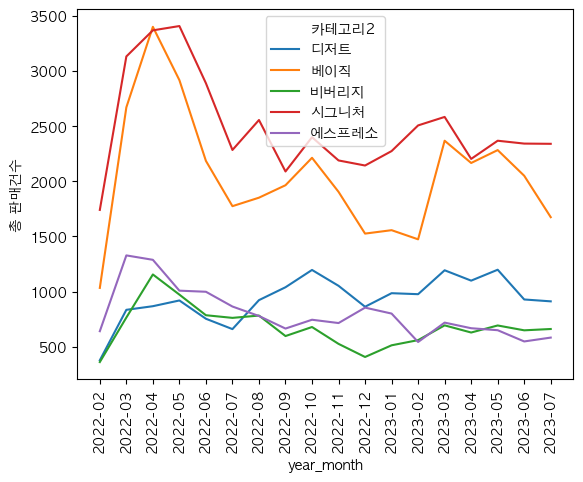

In [27]:
sns.lineplot(data = offline_df2.groupby(['year_month', '카테고리2']).count()[['결제시간']].reset_index(),
             x = 'year_month', y = '결제시간', hue = '카테고리2')

plt.xticks(rotation = 90)
plt.ylabel('총 판매건수')

Text(0, 0.5, '총 판매금액')

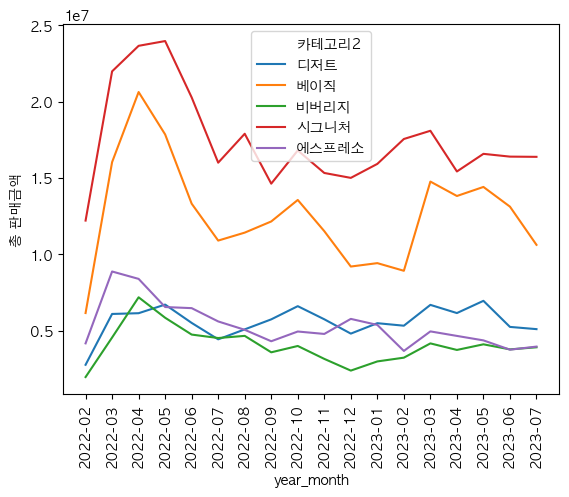

In [28]:
sns.lineplot(data = offline_df2.groupby(['year_month', '카테고리2']).sum()[['상품별 단가']].reset_index(),
             x = 'year_month', y = '상품별 단가', hue = '카테고리2')

plt.xticks(rotation = 90)
plt.ylabel('총 판매금액')

일별 평균 판매량은 주말이 평일보다 조금 높게 형성됨

Text(0, 0.5, '평균 판매량')

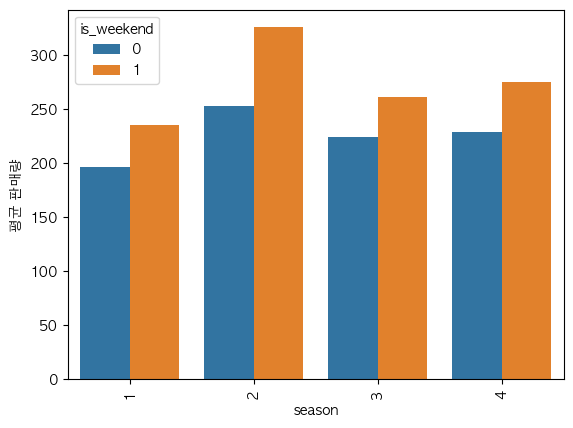

In [40]:
tmp = offline_df2[offline_df2['결제일'] > '2022-02-07'].groupby(['결제일', 'season', 'is_weekend']).count()[['상품별 단가']].reset_index()

sns.barplot(data = tmp.groupby(['season', 'is_weekend']).mean()[['상품별 단가']].reset_index(),
             x = 'season', y = '상품별 단가', hue = 'is_weekend')

plt.xticks(rotation = 90)
plt.ylabel('평균 판매량')

Text(0, 0.5, '평균 판매 금액')

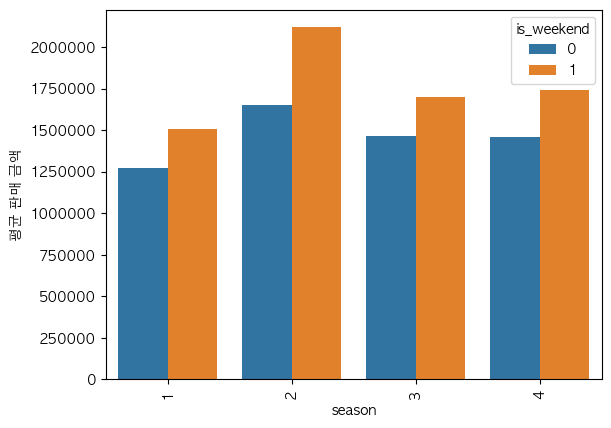

In [42]:
tmp = offline_df2[offline_df2['결제일'] > '2022-02-07'].groupby(['결제일', 'season', 'is_weekend']).sum()[['상품별 단가']].reset_index()

sns.barplot(data = tmp.groupby(['season', 'is_weekend']).mean()[['상품별 단가']].reset_index(),
             x = 'season', y = '상품별 단가', hue = 'is_weekend')

plt.xticks(rotation = 90)
plt.ylabel('평균 판매 금액')

Text(0, 0.5, '평균 판매 금액')

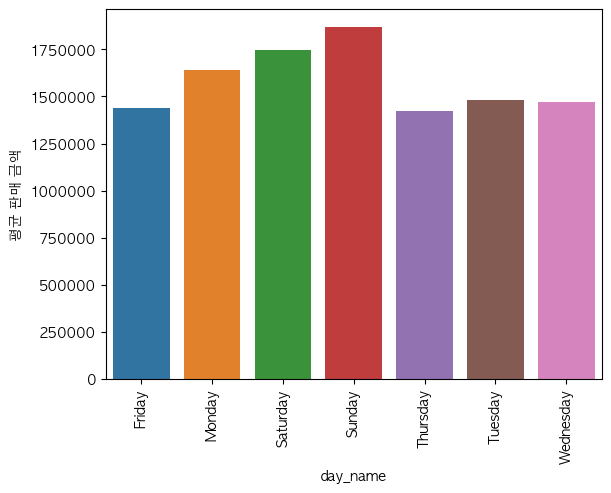

In [134]:
tmp = offline_df2[offline_df2['결제일'] > '2022-02-07'].groupby(['결제일', 'day_name']).sum()[['상품별 단가']].reset_index()

sns.barplot(data = tmp.groupby(['day_name']).mean()[['상품별 단가']].reset_index(),
             x = 'day_name', y = '상품별 단가')

plt.xticks(rotation = 90)
plt.ylabel('평균 판매 금액')

In [44]:
tmp2 = offline_df2[offline_df2['결제일'] > '2022-02-07'].groupby(['결제일', '카테고리2', '상품재분류']).sum()[['상품별 단가']].reset_index()

Text(0, 0.5, '누적 판매금액')

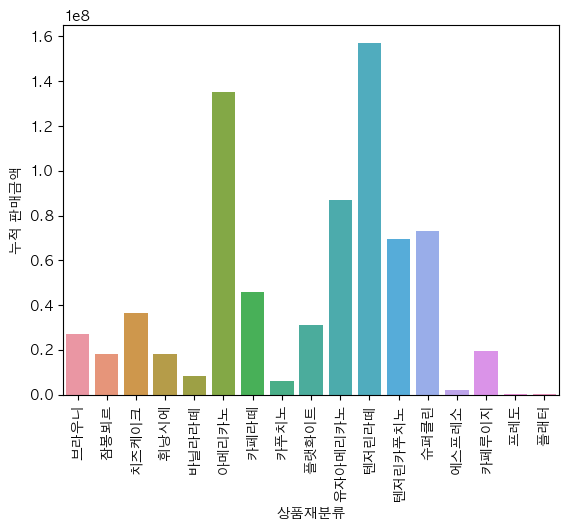

In [49]:
sns.barplot(data = tmp2.groupby(['카테고리2', '상품재분류']).sum().reset_index(),
            x = '상품재분류', y = '상품별 단가')
plt.xticks(rotation = 90)
plt.ylabel('누적 판매금액')

In [51]:
offline_df2[offline_df2['결제일'] > '2022-02-07'].groupby(['결제일', '카테고리2', '상품재분류']).sum()[['상품별 단가']].reset_index()



,결제일,카테고리2,상품재분류,상품별 단가
0,2022-02-10,디저트,브라우니,39000
1,2022-02-10,디저트,잠봉뵈르,34000
2,2022-02-10,디저트,치즈케이크,15000
3,2022-02-10,베이직,아메리카노,218000
4,2022-02-10,베이직,카페라떼,49000
...,...,...,...,...
6716,2023-07-31,베이직,플랫화이트,19500
6717,2023-07-31,시그니처,유자아메리카노,238000
6718,2023-07-31,시그니처,텐저린라떼,231000
6719,2023-07-31,시그니처,텐저린카푸치노,56000


In [100]:
records = offline_df2[["결제일시", "상품재분류", "카테고리2"]]
records = records.dropna()
records.loc[records["카테고리2"] == "핸드드립", "상품재분류"] = records.loc[records["카테고리2"] == "핸드드립", "상품재분류"].apply(lambda x : re.sub(r"\(H\)|\(I\)", "", x ))
records.loc[records["카테고리2"] == "핸드드립", "상품재분류"] = records.loc[records["카테고리2"] == "핸드드립", "상품재분류"].apply(lambda x : x.split("_")[0])


records = records.groupby("결제일시").agg({"카테고리2" : lambda x : '_'.join(sorted(list(set(x))))}).reset_index()
records = records[records["카테고리2"].apply(lambda x : True if len(x) > 5 else False)]
records['결제시간'] = records['결제일시'].map(lambda x: x.hour)
records['결제일'] = records['결제일시'].map(lambda x : x.date())

records['결제연월'] = records['결제일'].map(lambda x: str(x)[:7])
records['결제월'] = records['결제일'].map(lambda x: x.month)
records['결제요일'] = records['결제일시'].map(lambda x : x.day_name())


,결제일시,카테고리2,결제시간,결제일,결제연월,결제월,결제요일
22827,2022-08-01 10:09:48,베이직_시그니처,10,2022-08-01,2022-08,8,Monday
22830,2022-08-01 10:40:49,디저트_베이직_시그니처_에스프레소,10,2022-08-01,2022-08,8,Monday
22831,2022-08-01 10:41:49,디저트_베이직,10,2022-08-01,2022-08,8,Monday
22832,2022-08-01 10:42:26,시그니처_에스프레소,10,2022-08-01,2022-08,8,Monday
22837,2022-08-01 11:23:28,시그니처_에스프레소,11,2022-08-01,2022-08,8,Monday
...,...,...,...,...,...,...,...
60549,2023-07-31 15:44:40,디저트_베이직,15,2023-07-31,2023-07,7,Monday
60550,2023-07-31 15:50:09,디저트_시그니처_에스프레소,15,2023-07-31,2023-07,7,Monday
60556,2023-07-31 16:20:11,시그니처_에스프레소,16,2023-07-31,2023-07,7,Monday
60559,2023-07-31 16:37:18,베이직_시그니처,16,2023-07-31,2023-07,7,Monday


### 최근 1년 거래 자료

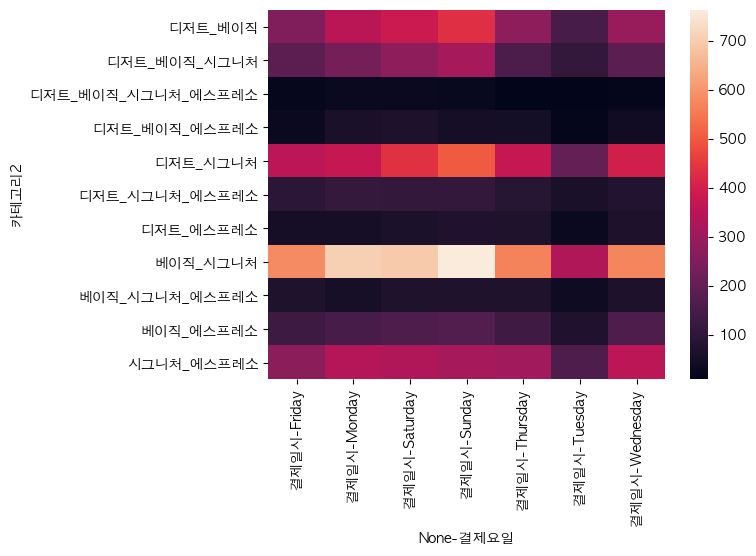

In [108]:
sns.heatmap(records[records['결제연월'] >= '2022-08'][['카테고리2', '결제요일', '결제일시']].groupby(['카테고리2', '결제요일']).count().unstack())

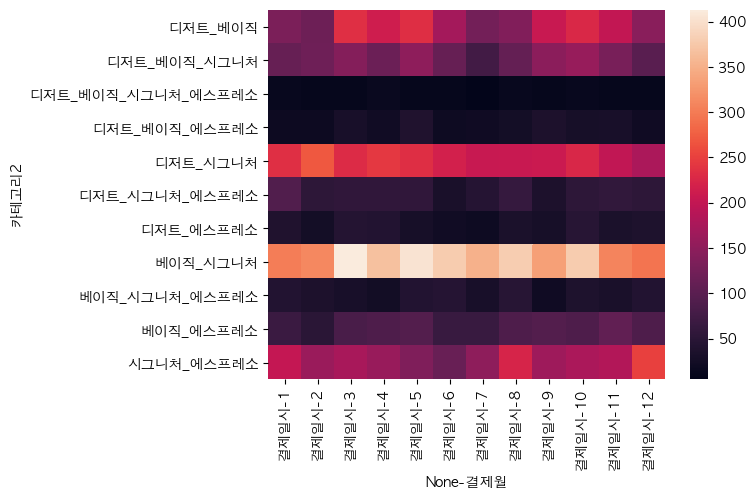

In [109]:
sns.heatmap(records[records['결제연월'] >= '2022-08'][['카테고리2', '결제월', '결제일시']].groupby(['카테고리2', '결제월']).count().unstack())

In [113]:
tmp3 = records[records['결제연월'] >= '2022-08'][['카테고리2', '결제연월', '결제일시']].groupby(['카테고리2', '결제연월']).count().reset_index()

In [119]:
tmp3['카테고리2'] = tmp3['카테고리2'].replace({'디저트_베이직' : '디저트_커피류', 
                         '디저트_베이직_시그니처' : '디저트_커피류',
                         '디저트_베이직_시그니처_에스프레소' : '디저트_커피류',
                         '디저트_베이직_에스프레소' : '디저트_커피류',
                         '디저트_시그니처' : '디저트_시그니처',
                         '디저트_시그니처_에스프레소' : '디저트_커피류',
                         '디저트_에스프레소' : '디저트_에스프레소', 
                         '베이직_시그니처' : '커피류', 
                         '베이직_시그니처_에스프레소' : '커피류',   
                         '베이직_에스프레소' : '커피류', 
                         '시그니처_에스프레소' : '커피류'})

Text(0, 0.5, '총 판매건수')

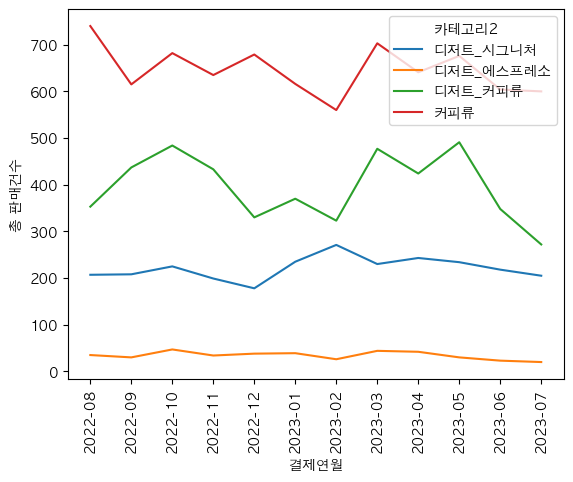

In [123]:
sns.lineplot(data = tmp3.groupby(['결제연월', '카테고리2']).sum().reset_index(),
             x = '결제연월', y = '결제일시', hue = '카테고리2')

plt.xticks(rotation = 90)
plt.ylabel('총 판매건수')

Text(0, 0.5, '최근 3개월 판매건수')

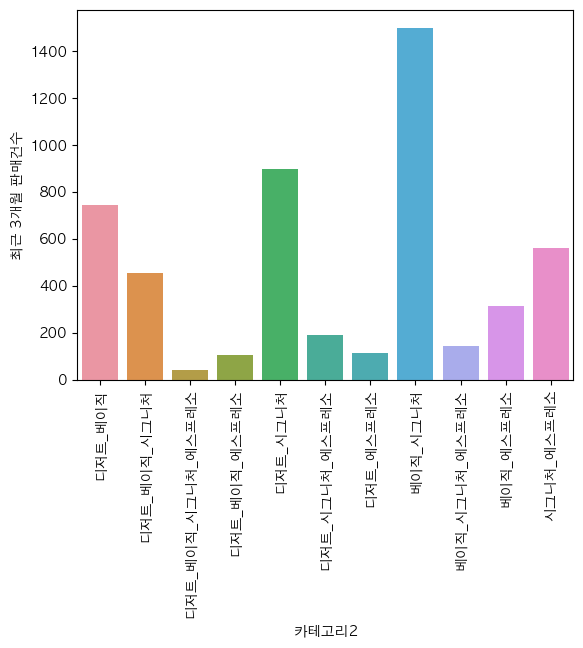

In [131]:
sns.barplot(data = records[records['결제연월'] >= '2023-04'].groupby(['카테고리2']).count()[['결제일시']].reset_index(),
            x = '카테고리2', y = '결제일시')
plt.xticks(rotation = 90)
plt.ylabel('최근 3개월 판매건수')